<a href="https://colab.research.google.com/github/skinnii/multimodal-ml/blob/main/individual-coding-assignment/individual_coding_assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Python Fundamentals

In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [57]:
url_author_info = 'https://raw.githubusercontent.com/skinnii/multimodal-ml/main/individual-coding-assignment-1/authorInfo.csv'
url_article_info = 'https://raw.githubusercontent.com/skinnii/multimodal-ml/main/individual-coding-assignment-1/articleInfo.csv'

author_info = pd.read_csv(url_author_info)
article_info = pd.read_csv(url_article_info)

In [58]:
df = pd.merge(author_info, article_info, on='Article No.', how='outer')

df.isna().sum()
df = df.fillna(0)

## 1.1: Yearly Publications

In [63]:
publications_per_year = df.groupby('Year').agg({'Article No.':'nunique'})
publications_per_year = publications_per_year.rename(columns={'Article No.':'Publications'})
publications_per_year

,Publications
Year,
2017,7
2018,10
2019,12
2020,36
2021,53
2022,46


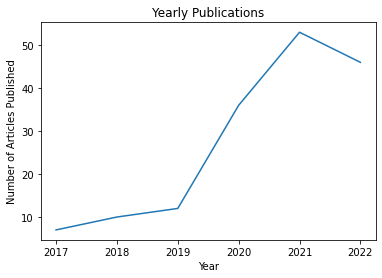

In [64]:
plt.plot(publications_per_year['Publications'])
plt.title('Yearly Publications')
plt.xlabel('Year')
plt.ylabel('Number of Articles Published')
plt.show()

## 1.2: Yearly citations

In [104]:
citations_per_year = df.groupby(['Year', 'Article No.']).agg({'Citation':'sum', 'Article No.':'count'})
citations_per_year['Citation'] = citations_per_year['Citation'] / citations_per_year['Article No.'] 
citations_per_year = citations_per_year.groupby(level='Year').agg({'Citation':'sum'})

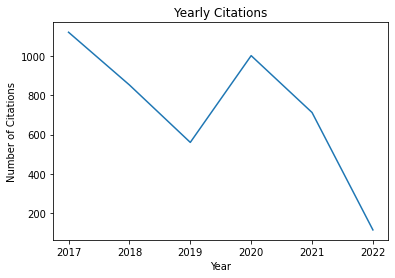

In [103]:
plt.plot(citations_per_year['Citation'])
plt.title('Yearly Citations')
plt.xlabel('Year')
plt.ylabel('Number of Citations')
plt.show()

## 1.3: Number of Publications Across Countries

In [105]:
!pip install pygal
!pip install pygal_maps_world

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 KB 4.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.8/270.8 KB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pygal_maps_world: filename=pygal_maps_world-1.0.2-py3-none-any.whl size=278560 sha256=8deeb5cf383bc118a4dffc04fe2364c0ac76c3950014118a858553446eda5eb9
  Stored in directory: /root/.cache/pip/wheels/da/f5/1b/a241a2b0e32fc89b08d1f42d37e63e7ccc2c820bb14fffd031
Successfully built pygal_maps_world


In [106]:
import pygal
from pygal_maps_world.maps import World
from pygal_maps_world.maps import COUNTRIES

In [108]:
worldmap_chart = World()
worldmap_chart.title = 'Number of Publications Per Country'

""" Replace bad / incompatible data """

df['Country'] = df['Country'].replace(
    ['Bristol', 'Denamrk', 'Chian', 'Chile ', 'Spain ', 'Israel ', 'Denmark ', 'Russia', 'Korea', 'Palestine', 'Taiwan', 'USA']
    , ['United Kingdom', 'Denmark', 'China', 'Chile', 'Spain', 'Israel', 'Denmark', 'Russian Federation', 'Korea, Republic of', 'Palestine, State of', 'Taiwan, Province of China', 'United States'])

""" Replace country name with country code """

for code, country in COUNTRIES.items():
    df['Country'] = df['Country'].replace([country], code)

publications_per_country = df.groupby(['Country']).agg({'Article No.':['nunique']}).sort_values(('Article No.', 'nunique'))
publications_per_country.rename(columns={('Article No.', 'nunique'): 'Publications'})

countries = publications_per_country.to_dict()

worldmap_chart.add('Number of Publications', countries[('Article No.', 'nunique')])
worldmap_chart.render_to_file('Number-of-Publications-Per-Countries.svg')


## 1.4: Top 5 Institutions

In [109]:
top_5_institutions = df.groupby('Author Affiliation').agg({'Article No.': 'nunique'}).sort_values('Article No.', ascending=False).head(6)
top_5_institutions[1:]

,Article No.
Author Affiliation,
Cyprus University of Technology,2
Malaysia University of Science and Technology,2
University of Bristol,2
University of Cambridge,2
Fudan University,2


## 1.5: Top 5 Researchers

In [110]:
top_5_researchers = df[['Author Name', 'h-index']].sort_values('h-index', ascending=False).head(5).reset_index(drop=True)
top_5_researchers

,Author Name,h-index
0,Ulrich Trautwein,95.0
1,Nicolas Molinari,63.0
2,George S. Athwal,59.0
3,Vicente A. González,33.0
4,Maria Luisa Lorusso,33.0


# 2. Regression

In [259]:
""" Import Libraries """

import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [260]:
""" Acquire Dataset """

url = 'https://raw.githubusercontent.com/skinnii/multimodal-ml/main/individual-coding-assignment-1/data.csv'
df = pd.read_csv(url)

In [261]:
""" Check For Missing Values """

df.isna().sum()
df = df.fillna(0)

""" Drop Unnecessary Column """

df = df.drop(columns = ['Unnamed: 6'])

In [269]:
""" Compute Pair-Wise Correlations """

""" The SUS scores seem to be positively correlated to the 'Purchase' metric (whether the customer
    purchased a ticket or not), and negatively correlated to both the 'Intent_Error' (the number of
    times the system failed to classify the user's intention) and 'ASR_Error' (the number of times)
    Siri failed to recognize the user's speech) metrics.  """
    
df.corr(method='pearson')['SUS'].sort_values()



Intent_Error   -0.693675
ASR_Error      -0.662405
Duration       -0.006631
Gender          0.111523
Purchase        0.661931
SUS             1.000000
Name: SUS, dtype: float64

In [265]:
""" Set up OLS Regression Model """

y = df['SUS'] # dependent variable
x = df.drop(columns='SUS') # predictor variables

In [266]:
x = sm.add_constant(x)
model = sm.OLS(y, x).fit()


## 2.1: Statistical Results

In [267]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    SUS   R-squared:                       0.593
Model:                            OLS   Adj. R-squared:                  0.571
Method:                 Least Squares   F-statistic:                     27.39
Date:                Wed, 15 Feb 2023   Prob (F-statistic):           5.25e-17
Time:                        03:08:59   Log-Likelihood:                -362.39
No. Observations:                 100   AIC:                             736.8
Df Residuals:                      94   BIC:                             752.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           93.0282      5.541     16.788   

## 2.2: Feature Analysis

Generally, a p-value less than 0.05 is required to determine which features are significant. 

"In most [cases], results yielding a p-value of .05 are considered on the borderline of statistical significance. If the p-value is under .01, results are considered statistically significant and if it's below .005 they are considered highly statistically significant."

Thus, looking at the model's summary, only the 'ASR_Error' and the 'Intent_Error' are statistically significant, with p-values of 0.001 and ~0.000, respectively. On the other hand, the 'Purchase', 'Duration', and 'Gender' are statistically insignificant as their p-values exceed the 0.5 threshold.

## 2.3: Expected Results

Duration: I expected the duration of the interaction between Siri and the user to perhaps be of importance. I reasoned that the longer it takes for a user to book (or not) his/her ticket, the more unpleasant the interaction would appear.

Purchase: Similarly, I thought the 'Purchase' variable would be more significant--especially since its pair-wise correlation seems to indicate so.

Gender: I expected the gender to be completely insignificant. No surprises there.

ASR_Error: I did expect the ASR_Error to play a role in prediciting SUS values. It makes sense that the more Siri fails to recognize a user's speech the worse that user's experience is. 

Intent_Error: Much like with the ASR_Error, I imagined the Intent_Error would be statistically significant and negatively correlated to the SUS scores. Again, it's easy to see how an increase in intention errors would lead to a decrease in satisfaction scores. 

## 2.4: Most Influential Factor

The most influential factor is the Intent_Error. With a p-value of 0.000, it is essentially 100% certain that a difference in outcomes would not be observed if it had no benefit whatsoever. In other words, it is highly statistically significant. Also, it has the absolute largest pair-wise correlation to the SUS score.

## 2.5: Explanation

Since the SUS parameter is a measure of customer satisfaction, it is easy to reason why factors such as Intent_Error and ASR_Error are so statisticaly significant. Put simply, the more errors the system makes, the least enjoyable the experience. 

# 3. Classification

In [1]:
""" Import Libraries """

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
""" Acquire Dataset """

url = 'https://raw.githubusercontent.com/skinnii/multimodal-ml/main/individual-coding-assignment-1/data.csv'
df = pd.read_csv(url)

In [3]:
""" Check For Missing Values """

df = df.fillna(0)
df.isna().sum()

Purchase        0
SUS             0
Duration        0
Gender          0
ASR_Error       0
Intent_Error    0
Unnamed: 6      0
dtype: int64

In [4]:
""" Drop Unnecessary Column """

df = df.drop(columns = ['Unnamed: 6', 'SUS'])

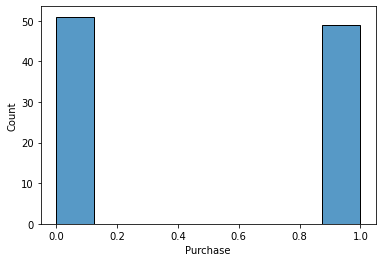

' Distribution appears to be fairly balanced. No need to oversample (SMOTE) '

In [5]:
""" Analyze Distribution """

sns.histplot(data=df['Purchase'], palette='bright')
plt.show()

""" Distribution appears to be fairly balanced. No need to oversample (SMOTE) """

In [6]:
""" Prepare Labels for Model Training """

y = df['Purchase'].to_numpy()
y

array([1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0,
       1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1])

In [7]:
""" Prepare Data for Model Training """

X = df.drop('Purchase', axis = 1).to_numpy()
X

array([[254,   0,   3,   2],
       [247,   0,   6,   9],
       [125,   1,   6,   8],
       [ 22,   0,  11,   7],
       [262,   0,   2,   3],
       [113,   1,   8,   9],
       [ 91,   1,   6,   3],
       [ 46,   0,   6,  11],
       [132,   0,   9,   9],
       [190,   0,  11,   4],
       [146,   0,   9,   7],
       [226,   0,   4,   4],
       [ 54,   1,   7,   9],
       [104,   0,   2,   3],
       [292,   0,   7,   3],
       [126,   0,   8,   9],
       [152,   1,   3,   5],
       [221,   0,   3,   4],
       [ 51,   0,   9,   9],
       [230,   0,   6,   8],
       [ 72,   1,   6,   8],
       [284,   0,   6,  11],
       [168,   0,   2,   4],
       [194,   0,   1,   3],
       [130,   1,  10,   1],
       [227,   0,   9,   3],
       [161,   1,   7,   8],
       [262,   1,   2,   3],
       [257,   1,   9,  11],
       [ 57,   1,   8,   3],
       [138,   0,   8,   9],
       [ 33,   1,   9,   4],
       [260,   0,   1,   2],
       [178,   1,   3,   4],
       [153,  

In [50]:
""" Data Scaling """

from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.model_selection import train_test_split

scale = StandardScaler()
scaled_X = scale.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size = 0.25)

In [51]:
""" Import Classifiers and Metrics from Sklearn """

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, roc_curve, auc, classification_report

import matplotlib.pyplot as plt

In [52]:
""" Initialize Logistic Regression, SVM, Naive Bayes, and Random Forest Classification Algorithms """

lc = LogisticRegression()
svc = SVC(probability=True)
nbc = GaussianNB()
rfc = RandomForestClassifier()

In [53]:
""" Train the Models with Training Dataset """

lc.fit(X_train, y_train)
svc.fit(X_train, y_train)
nbc.fit(X_train, y_train)
rfc.fit(X_train, y_train)

RandomForestClassifier()

In [54]:
""" Test the Models with Testing Dataset """

y_lc_predicted = lc.predict(X_test)
y_lc_pred_proba = lc.predict_proba(X_test)

y_svc_predicted = svc.predict(X_test)
y_svc_pred_proba = svc.predict_proba(X_test)

y_nbc_predicted = nbc.predict(X_test)
y_nbc_pred_proba = nbc.predict_proba(X_test)

y_rfc_predicted = rfc.predict(X_test)
y_rfc_pred_proba = rfc.predict_proba(X_test)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      1.00      1.00        13

    accuracy                           1.00        25
   macro avg       1.00      1.00      1.00        25
weighted avg       1.00      1.00      1.00        25

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      1.00      1.00        13

    accuracy                           1.00        25
   macro avg       1.00      1.00      1.00        25
weighted avg       1.00      1.00      1.00        25

              precision    recall  f1-score   support

           0       0.92      1.00      0.96        12
           1       1.00      0.92      0.96        13

    accuracy                           0.96        25
   macro avg       0.96      0.96      0.96        25
weighted avg       0.96      0.96      0.96        25

              preci

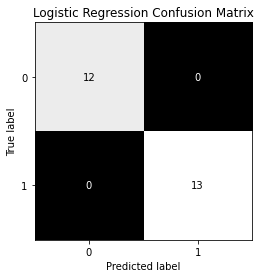

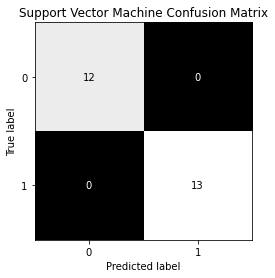

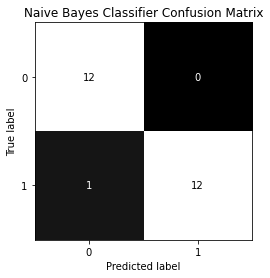

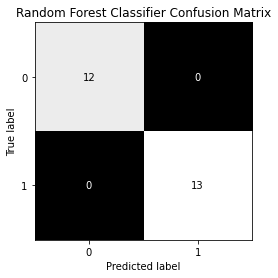

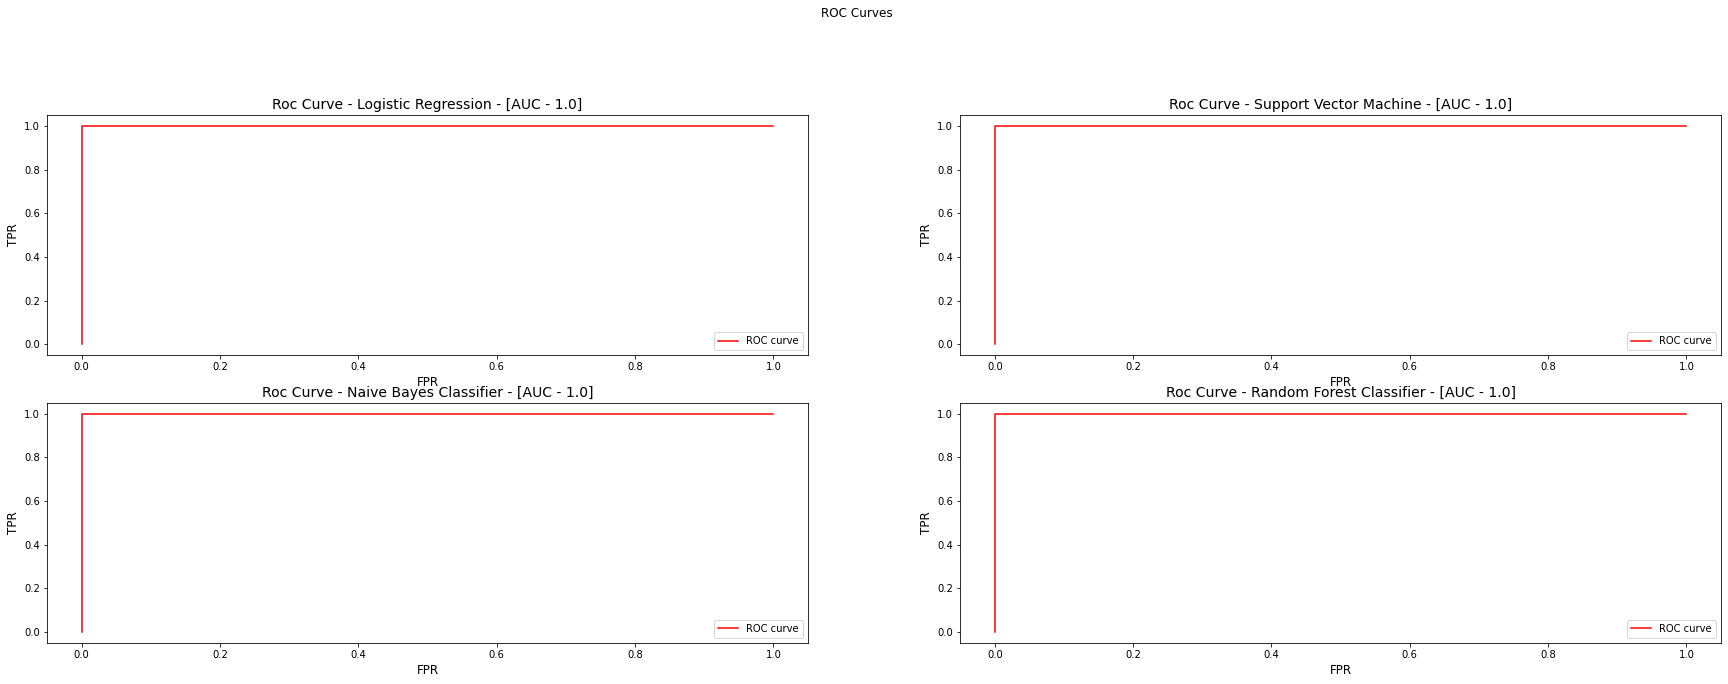

In [55]:
""" Model Evaluation with Confusion Matrix and ROC Curve """

print(classification_report(y_test, y_lc_predicted))
print(classification_report(y_test, y_svc_predicted))
print(classification_report(y_test, y_nbc_predicted))
print(classification_report(y_test, y_rfc_predicted))

models = ['Logistic Regression', 'Support Vector Machine', 'Naive Bayes Classifier', 'Random Forest Classifier']
predictions = [y_lc_predicted, y_svc_predicted, y_nbc_predicted, y_rfc_predicted]
pred_probabilities = [y_lc_pred_proba, y_svc_pred_proba, y_nbc_pred_proba, y_rfc_pred_proba]

plot = 1

for model, prediction, pred_proba in zip(models, predictions, pred_probabilities):
    disp = ConfusionMatrixDisplay(confusion_matrix(y_test.ravel(), prediction))
    disp.plot(
        include_values=True,
        cmap='gray',
        colorbar=False
    )
    disp.ax_.set_title(f"{model} Confusion Matrix")

plt.figure(figsize=(30, 15))
plt.suptitle("ROC Curves")
plot_index = 1

for model, prediction, pred_proba in zip(models, predictions, pred_probabilities):
    fpr, tpr, thresholds = roc_curve(y_test, pred_proba[:, 1])
    auc_score = auc(fpr, tpr)
    plt.subplot(3, 2, plot_index)
    plt.plot(fpr, tpr, 'r', label='ROC curve')
    # pyplot.figure(figsize=(5, 5))
    plt.title(f'Roc Curve - {model} - [AUC - {auc_score}]', fontsize=14)
    plt.xlabel('FPR', fontsize=12)
    plt.ylabel('TPR', fontsize=12)
    plt.legend()
    plot_index += 1
    
plt.show()